In [148]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

In [11]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

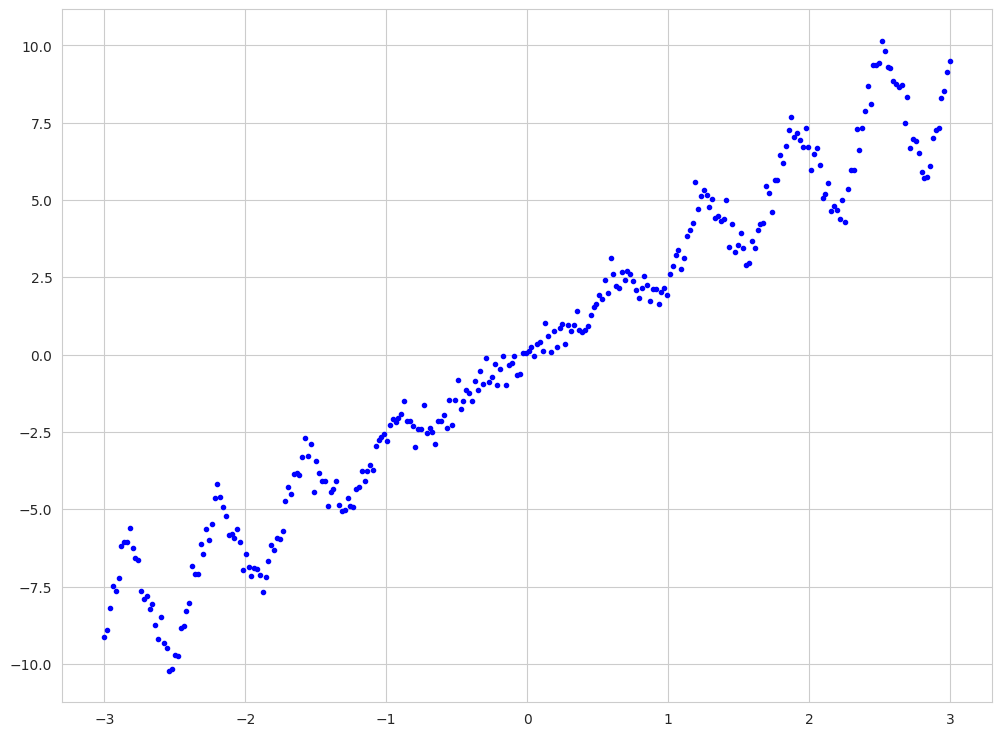

In [12]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [35]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии (с видоизменениями)
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$", label=None):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X.reshape(-1), y.reshape(-1), "b.", alpha=0.3) # Исходные данные
    plt.plot(x1, y_pred, linewidth=2, label=label) # Предсказания модели

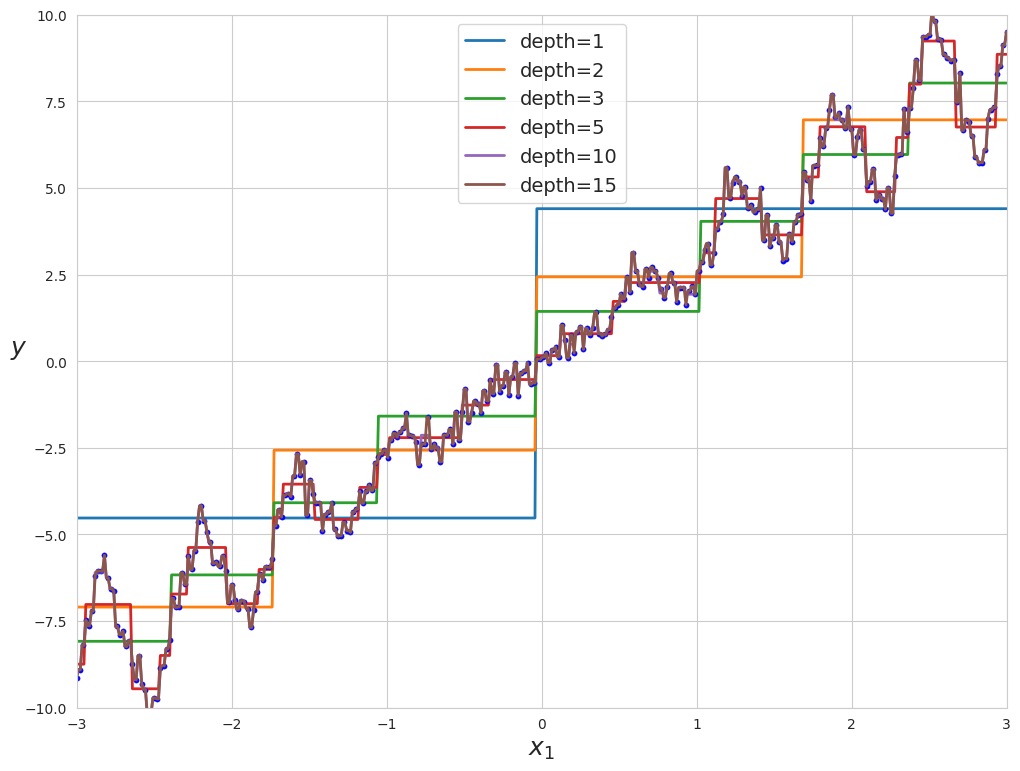

In [39]:
# Построение моделей с различной глубиной дерева и их визуализация
for depth in [1, 2, 3, 5, 10, 15]:
    tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_reg.fit(X, y)
    plot_regression_predictions(tree_reg, X, y, ylabel=None if depth != 1 else "$y$", label=f"depth={depth}")
    plt.legend(loc="upper center", fontsize=14)

plt.show()

На мой взгляд оптимально при глубине 10, при 15 слишком большое

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [43]:
# Функция для расчета биномиального коэффициента
def binom_coeff(n, k):
    return math.factorial(n) / (math.factorial(k) * math.factorial(n - k))
# Функция для расчета вероятности голосования
def majority_vote_prob(p):
    mu = 0
    for i in range(51, 102):
        mu += binom_coeff(101, i) * (p ** i) * ((1 - p) ** (101 - i))
    return mu

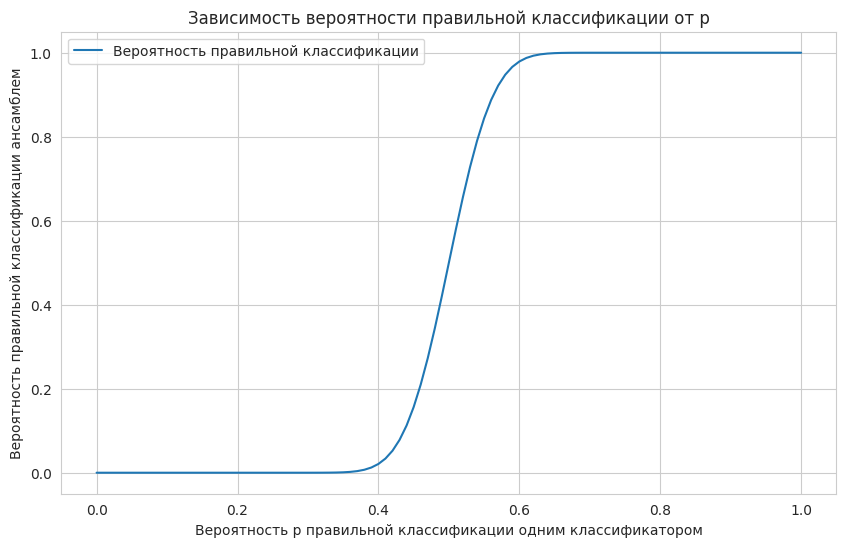

In [44]:
# Генерируем значения p от 0 до 1 с шагом 0.01
p_values = np.linspace(0, 1, 101)
# Рассчитываем вероятность правильной классификации для каждого значения p
probabilities = [majority_vote_prob(p) for p in p_values]
# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(p_values, probabilities, label='Вероятность правильной классификации')
plt.xlabel('Вероятность p правильной классификации одним классификатором')
plt.ylabel('Вероятность правильной классификации ансамблем')
plt.title('Зависимость вероятности правильной классификации от p')
plt.legend()
plt.grid(True)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

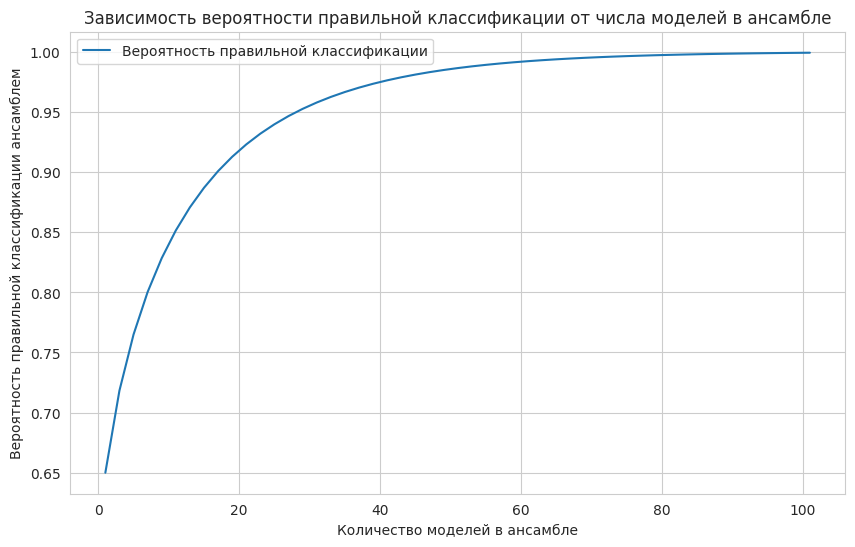

In [46]:
# Фиксированная вероятность правильной классификации одной моделью
p = 0.65
# Диапазон количества моделей в ансамбле
n_models = range(1, 102, 2)  # Используем нечетное количество моделей для избежания ничьих
# Рассчитываем вероятность правильной классификации для каждого количества моделей
probabilities = [ensemble_vote_prob(n, p) for n in n_models]
# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(n_models, probabilities, label='Вероятность правильной классификации')
plt.xlabel('Количество моделей в ансамбле')
plt.ylabel('Вероятность правильной классификации ансамблем')
plt.title('Зависимость вероятности правильной классификации от числа моделей в ансамбле')
plt.legend()
plt.grid(True)
plt.show()

Опишите ваши наблюдения:

* С увеличением p вероятность правильной классификации ансамблем значительно возрастает, особенно когда p превышает 0.5
* Поэтому важно иметь классификаторы, которые работают лучше случайного угадывания, поскольку даже небольшое улучшение в производительности отдельных классификаторов может значительно увеличить общую производительность ансамбля
* С увеличением количества моделей в ансамбле вероятность правильной классификации ансамблем увеличивается
* Если каждый классификатор в ансамбле имеет лишь умеренную производительность, их комбинация может достичь значительно более высокой точности

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [68]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = np.unique(y)

        n_samples, n_features = X.shape
        self.feat_ids_by_tree = []

        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)

            # Выбор признаков без возвращения
            if self.max_features is None:
                self.max_features = n_features
            feat_ids = np.random.choice(n_features, self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)

            # Бутстрэп выборка
            sample_ids = np.random.choice(n_samples, n_samples, replace=True)
            X_sample, y_sample = X[sample_ids][:, feat_ids], y[sample_ids]

            # Обучение дерева
            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

        return self

    def predict_proba(self, X):
        probas = np.array([tree.predict_proba(X[:, feat_ids]) for tree, feat_ids in zip(self.trees, self.feat_ids_by_tree)])
        avg_proba = np.mean(probas, axis=0)
        return avg_proba

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions


Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [69]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

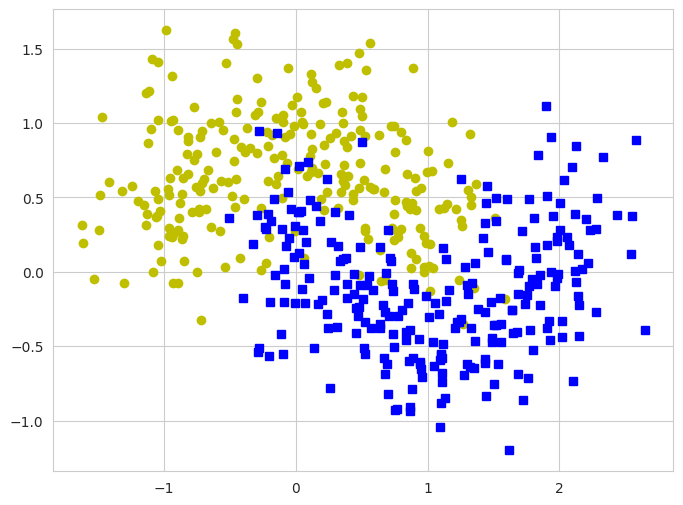

In [70]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [71]:
# Создание и обучение модели
rf_custom = RandomForestClassifierCustom(n_estimators=100, max_depth=None, max_features=None, random_state=42)
rf_custom.fit(X, y)

RandomForestClassifierCustom(max_features=2, n_estimators=100, random_state=42)

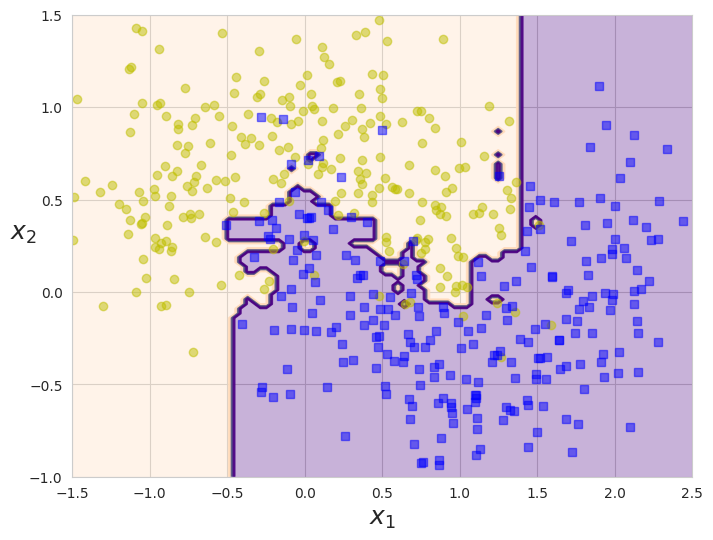

In [72]:
# Визуализация
plt.figure(figsize=(8, 6))
plot_decision_boundary(rf_custom, X, y)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [74]:
def search_best_params(X, y, n_estimators_list, max_depth_list, max_features_list):
    best_score = 0
    best_params = {}
    n_features = X.shape[1]
    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            for max_features in max_features_list:
                # Преобразование строковых значений max_features в числа
                if max_features == 'sqrt':
                    max_features_num = int(np.sqrt(n_features))
                elif max_features == 'log2':
                    max_features_num = int(np.log2(n_features))
                else:
                    max_features_num = max_features

                rf_custom = RandomForestClassifierCustom(n_estimators=n_estimators,
                                                         max_depth=max_depth,
                                                         max_features=max_features_num,
                                                         random_state=42)
                scores = cross_val_score(rf_custom, X, y, cv=5, scoring='accuracy')
                mean_score = scores.mean()
                if mean_score > best_score:
                    best_score = mean_score
                    best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features}
    return best_score, best_params
# Параметры для перебора
n_estimators_list = [10, 50, 100]
max_depth_list = [None, 5, 10, 20]
max_features_list = [None, 'sqrt', 'log2']  # Теперь корректно обрабатываются строковые значения
# Поиск лучших гиперпараметров
best_score, best_params = search_best_params(X, y, n_estimators_list, max_depth_list, max_features_list)
print("Лучшая точность:", best_score)
print("Лучшие гиперпараметры:", best_params)

Лучшая точность: 0.9279999999999999
Лучшие гиперпараметры: {'n_estimators': 100, 'max_depth': None, 'max_features': None}


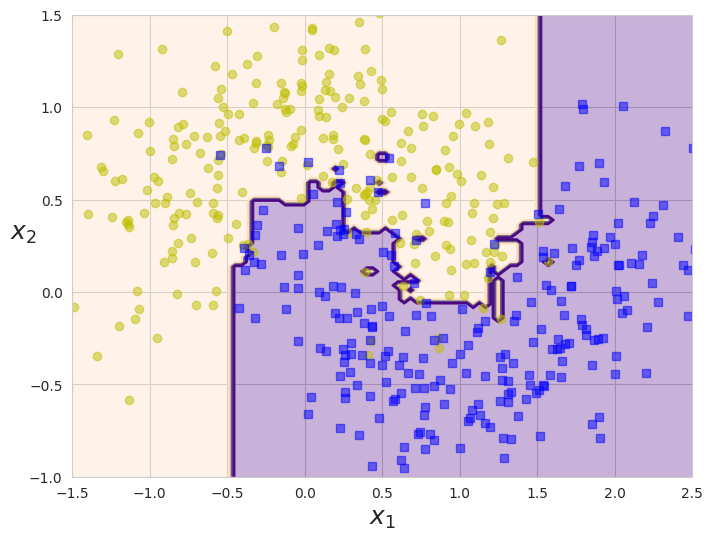

In [77]:
# Создание экземпляра с оптимальными параметрами
rf_custom_optimal = RandomForestClassifierCustom(n_estimators=100, max_depth=None, max_features=None, random_state=42)
# Генерация искусственных данных
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=42)
# Обучение модели
rf_custom_optimal.fit(X, y)
# Визуализация разделяющей границы для оптимальной модели
plt.figure(figsize=(8, 6))
plot_decision_boundary(rf_custom_optimal, X, y)
plt.show()

Вроде неплохо выглядит

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [78]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [79]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [81]:
# Функция для расчет попарных корреляций
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        ypred_t1 = est1.predict_proba(X)[:, 1]
        ypred_t2 = est2.predict_proba(X)[:, 1]
        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

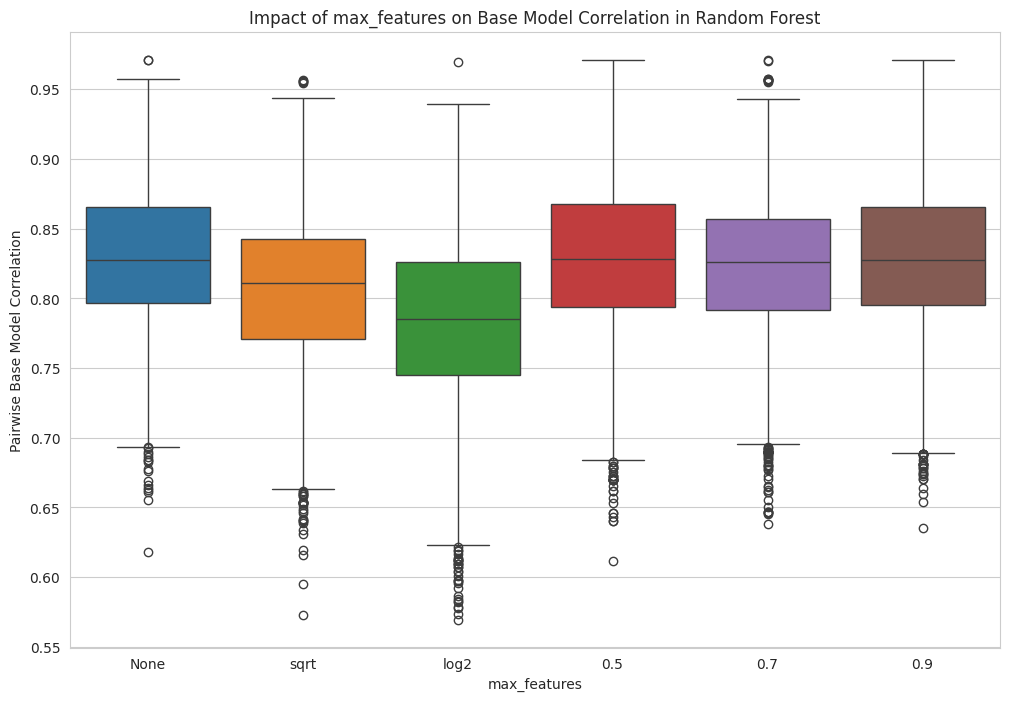

In [82]:
# Значения max_features для анализа
max_features_values = [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
correlations = []
for max_features in max_features_values:
    # Создание и обучение случайного леса
    rf = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state=42)
    rf.fit(X_train, y_train)
    # Расчет попарных корреляций
    corrs = base_model_pair_correlation(rf, X_test)
    correlations.append(corrs)
# Визуализация результатов
plt.figure(figsize=(12, 8))
sns.boxplot(data=correlations)
plt.xticks(range(len(max_features_values)), labels=[str(mf) for mf in max_features_values])
plt.xlabel('max_features')
plt.ylabel('Pairwise Base Model Correlation')
plt.title('Impact of max_features on Base Model Correlation in Random Forest')
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

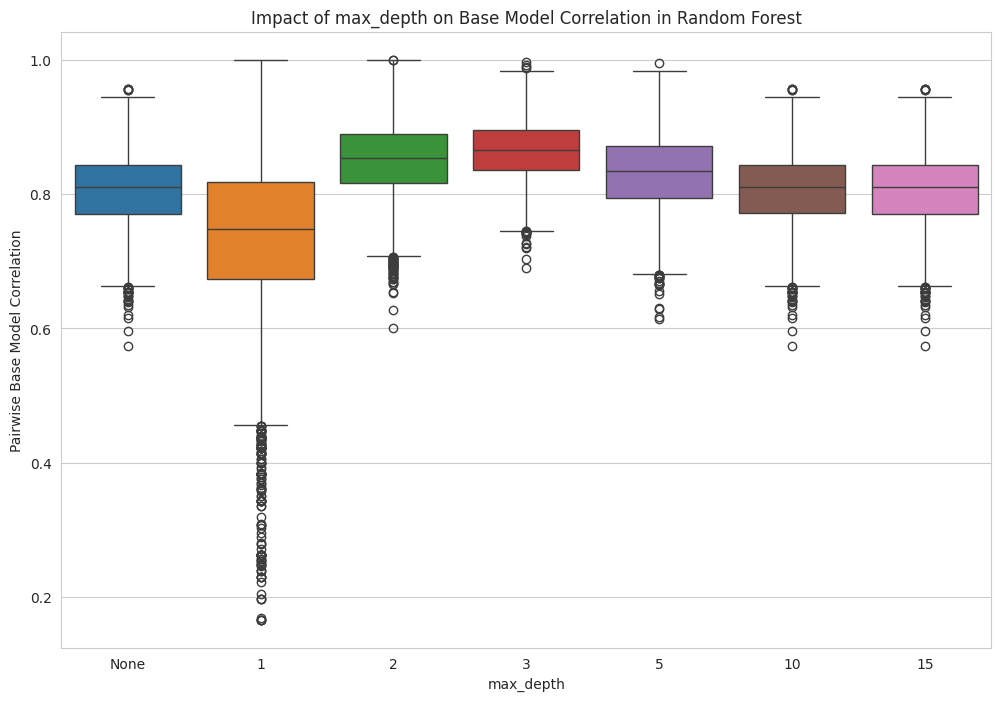

In [83]:
# Значения max_depth для анализа
max_depth_values = [None, 1, 2, 3, 5, 10, 15]
correlations_depth = []

for max_depth in max_depth_values:
    # Создание и обучение случайного леса
    rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)

    # Расчет попарных корреляций
    corrs = base_model_pair_correlation(rf, X_test)
    correlations_depth.append(corrs)

# Визуализация результатов
plt.figure(figsize=(12, 8))
sns.boxplot(data=correlations_depth)
plt.xticks(range(len(max_depth_values)), labels=[str(md) if md is not None else 'None' for md in max_depth_values])
plt.xlabel('max_depth')
plt.ylabel('Pairwise Base Model Correlation')
plt.title('Impact of max_depth on Base Model Correlation in Random Forest')
plt.show()

Опишите ваши наблюдения:

* При использовании деревьев с небольшой глубиной (например, max_depth=1) корреляция между предсказаниями отдельных деревьев ниже
* По мере увеличения max_depth корреляция между предсказаниями возрастает, а затем немного снижается

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [84]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [85]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [87]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()
base_models = [("DT", dt), ("RF", rf),
               ("ETC", etc), ("KNN", knn),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),
               ("CAT", cat), ("LGBM", lgbm),
               ("LGBM_RF", lgbm_rf), ("XGB", xgb),
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [89]:
voting_hard = VotingClassifier(estimators=[('dt', dt), ('rf', rf), ('cat', cat), ('etc', etc), ('knn', knn),
                                           ('svc_lin', svc_lin), ('svc_rbf', svc_rbf), ('xgb', xgb), ('lgbm', lgbm),
                                           ('lr', lr), ('nb', nb)], voting='hard')
voting_soft = VotingClassifier(estimators=[('dt', dt), ('rf', rf), ('cat', cat), ('etc', etc), ('knn', knn),
                                           ('svc_lin', svc_lin), ('svc_rbf', svc_rbf), ('xgb', xgb), ('lgbm', lgbm),
                                           ('lr', lr), ('nb', nb)], voting='soft')

# Оценка качества моделей с помощью кросс-валидации
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]:
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

VotingClassifier: 0.8503633581946834

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [93]:
voting_soft.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=10,
                                                     random_state=111)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=111)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x787a215deec0>),
                             ('etc', ExtraTreesClassifier(random_state=111)),
                             ('knn', KNeighborsClassifier(weights='distance')),
                             ('svc_lin',
                              SVC(...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=111, ...)),
                             ('lgbm', LGBMClassifier(random_state=111)),
                             ('lr',
                              LogisticRegression(max_iter=10000,
                                                 solver='liblinear')),
                             ('nb', GaussianNB())],
                 voting='soft')

In [103]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X
        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)
        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))
    return corrs

In [104]:
corrs = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
corrs_df = pd.DataFrame(corrs, columns=['Model 1', 'Model 2', 'Correlation'])
corrs_df['Model 1'] = corrs_df['Model 1'].apply(lambda x: x.__class__.__name__)
corrs_df['Model 2'] = corrs_df['Model 2'].apply(lambda x: x.__class__.__name__)
# Сортировка результатов по убыванию корреляции
corrs_df = corrs_df.sort_values(by='Correlation', ascending=False)
# Вывод первых 10 пар моделей с наивысшей корреляцией
corrs_df.head(10)

,Model 1,Model 2,Correlation
49,XGBClassifier,LGBMClassifier,0.970839
24,CatBoostClassifier,LGBMClassifier,0.955278
19,CatBoostClassifier,ExtraTreesClassifier,0.952720
43,SVC,LogisticRegression,0.952159
10,RandomForestClassifier,CatBoostClassifier,0.945070
23,CatBoostClassifier,XGBClassifier,0.933990
11,RandomForestClassifier,ExtraTreesClassifier,0.921565
16,RandomForestClassifier,LGBMClassifier,0.914687
15,RandomForestClassifier,XGBClassifier,0.896641
31,ExtraTreesClassifier,LGBMClassifier,0.892875


Наиболее высокая корреляция наблюдается между XGBClassifier и LGBMClassifier, что указывает на то, что эти две модели делают очень похожие предсказания. Аналогично, CatBoostClassifier и LGBMClassifier также показывают высокую корреляцию.

In [ ]:
models_list = [("DT", dt), ("RF", rf),
               ("ETC", etc), ("KNN", knn),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),
               ("CAT", cat), ("LGBM", lgbm),
               ("LGBM_RF", lgbm_rf), ("XGB", xgb),
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
def evaluate_ensemble(models, X_train, y_train, X_test, y_test):
    estimators = [(model.__class__.__name__ + str(i), model) for i, model in enumerate(models)]
    voting_clf = VotingClassifier(estimators=estimators, voting='soft')
    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_test)
    score = f1_score(y_test, y_pred)
    return score
best_score = 0
best_combination = None
for L in range(2, len(models_list) + 1):
    for subset in combinations(models_list, L):
        score = evaluate_ensemble(subset, X_train, y_train, X_test, y_test)
        if score > best_score:
            best_score = score
            best_combination = subset
# Выводим наилучшую комбинацию и ее производительность
print(f"Лучший F1-скор: {best_score}")
print("Лучшая комбинация моделей:")
for model in best_combination:
    print(model.__class__.__name__)

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель.

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

  State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.

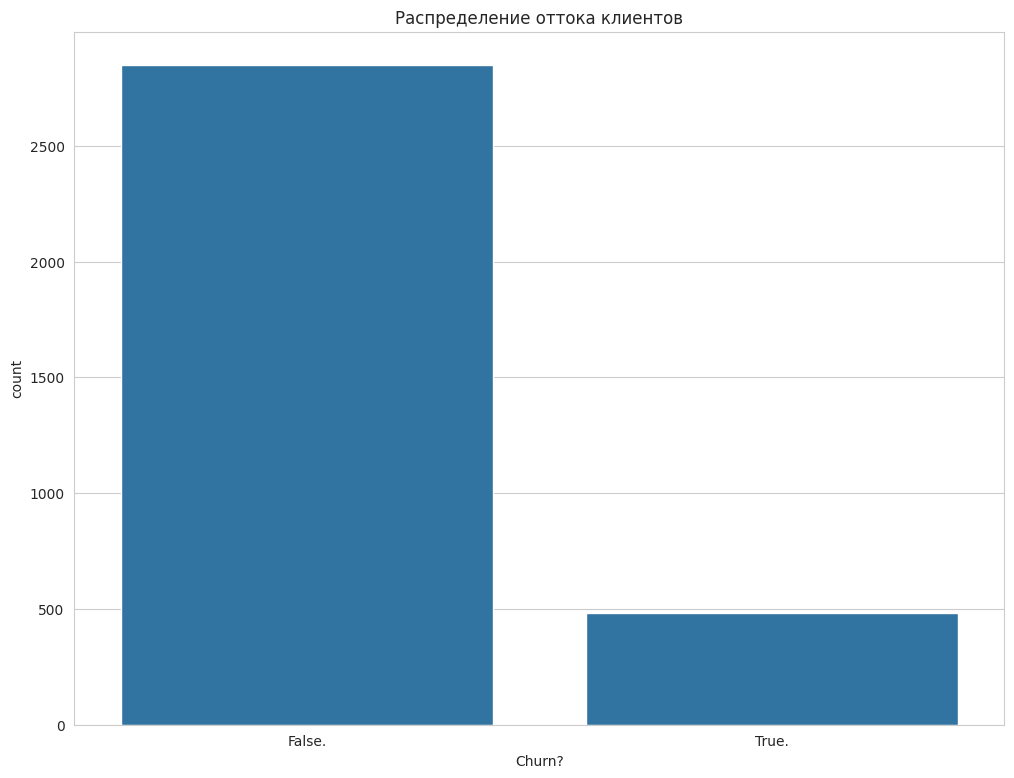

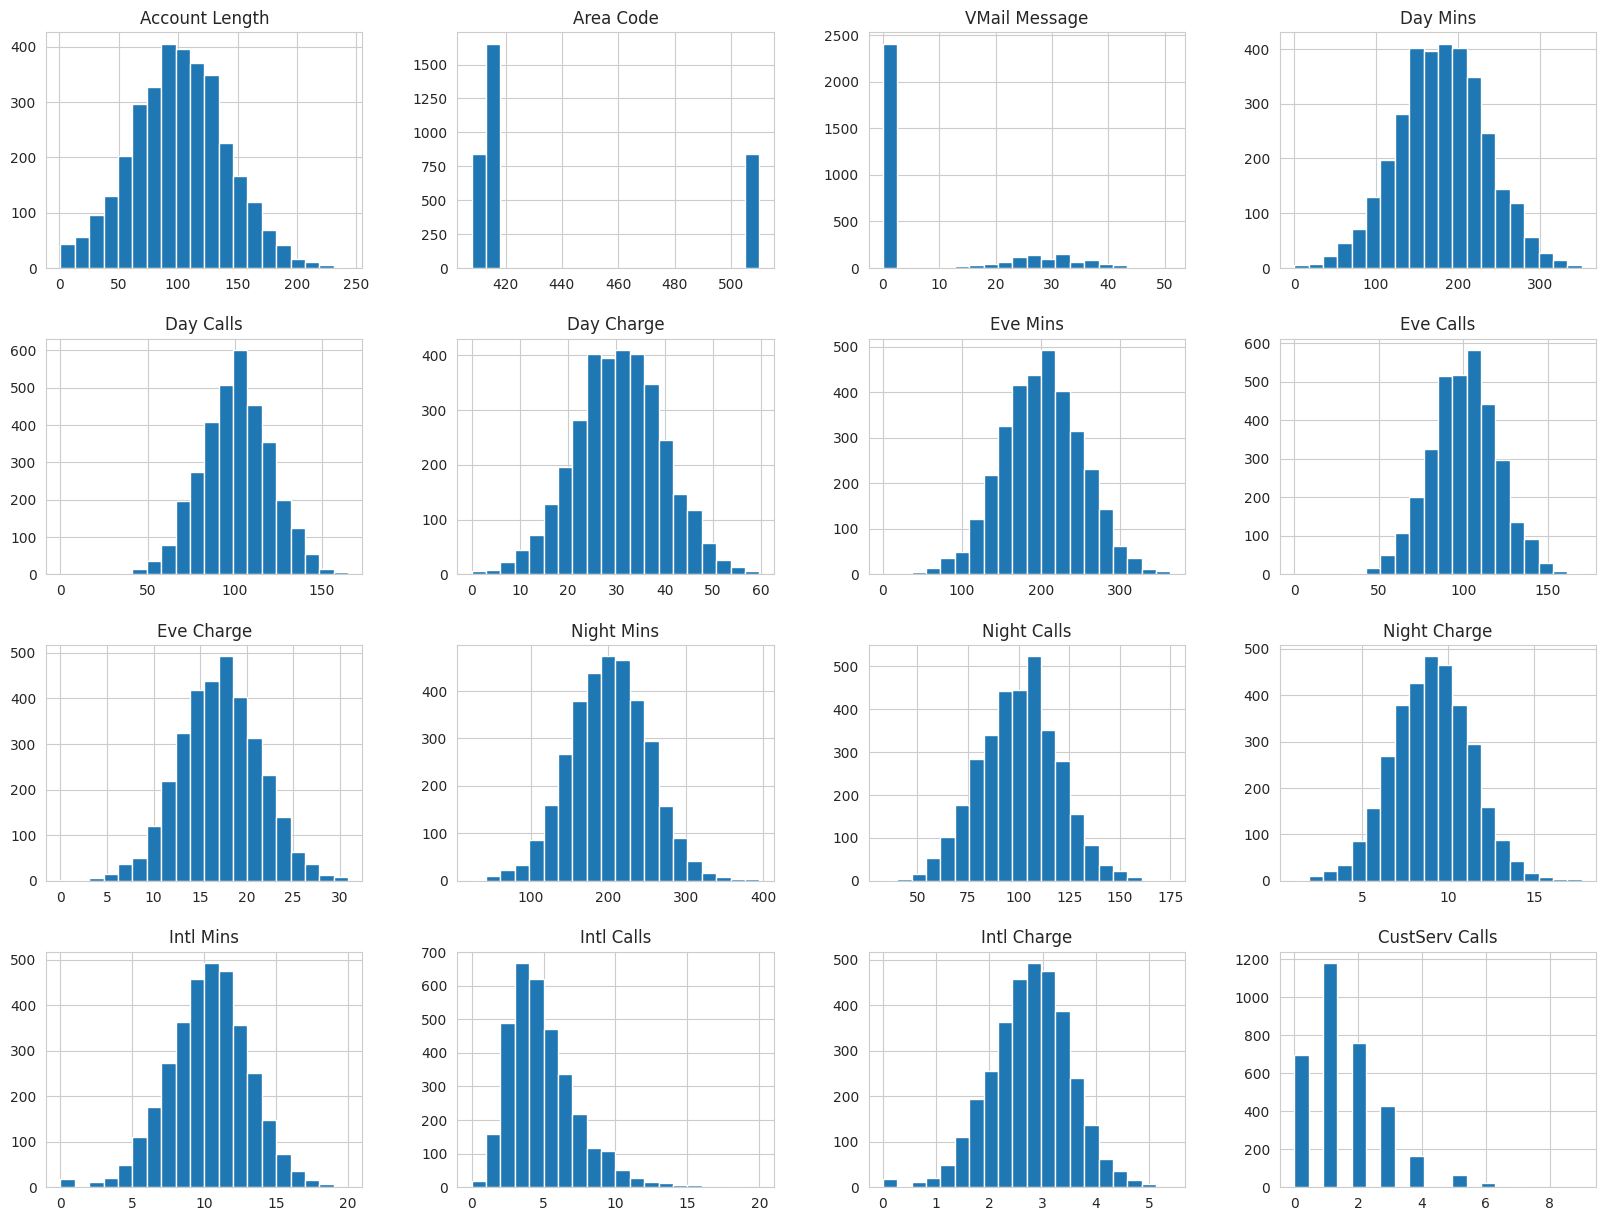

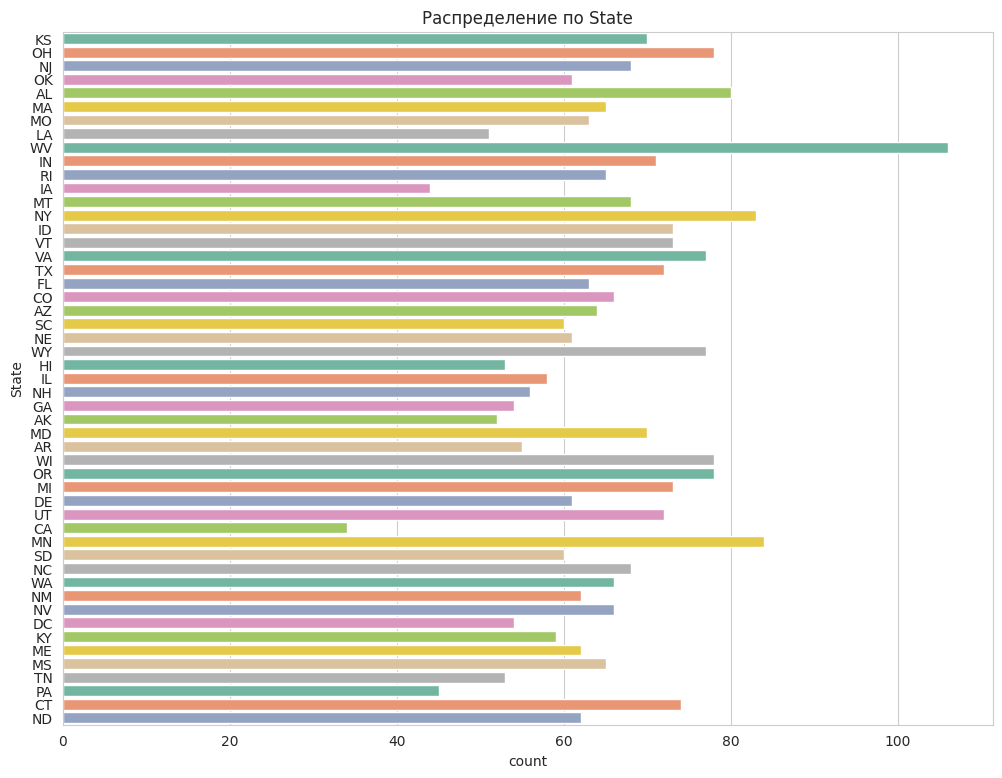

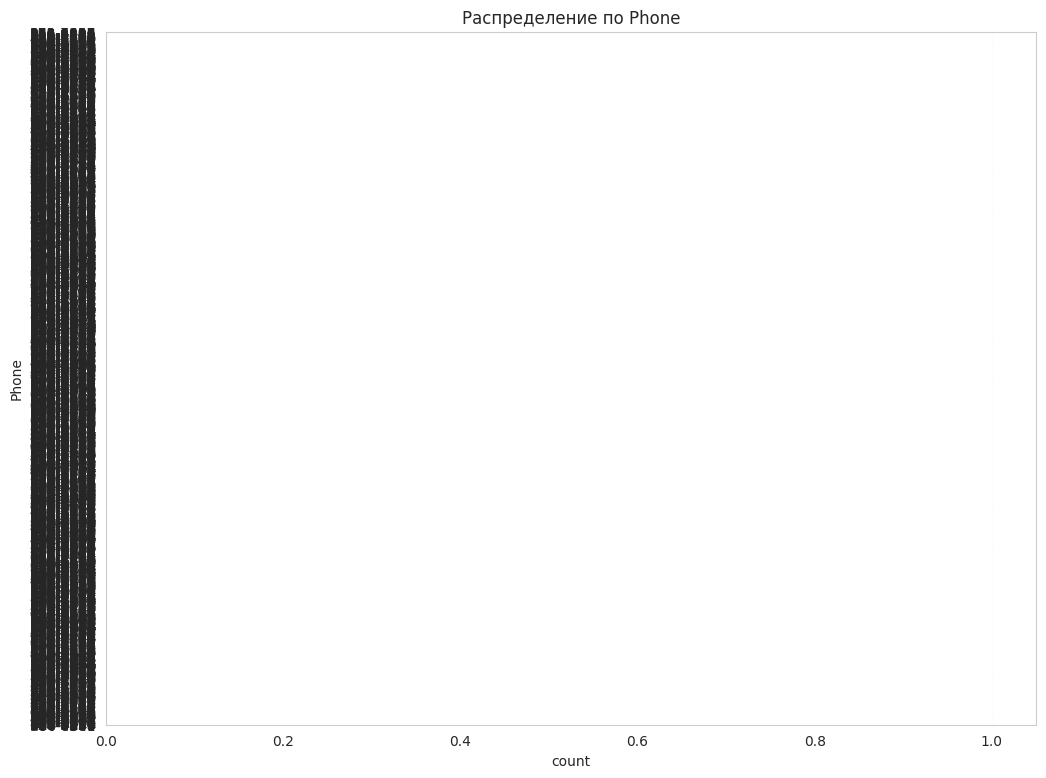

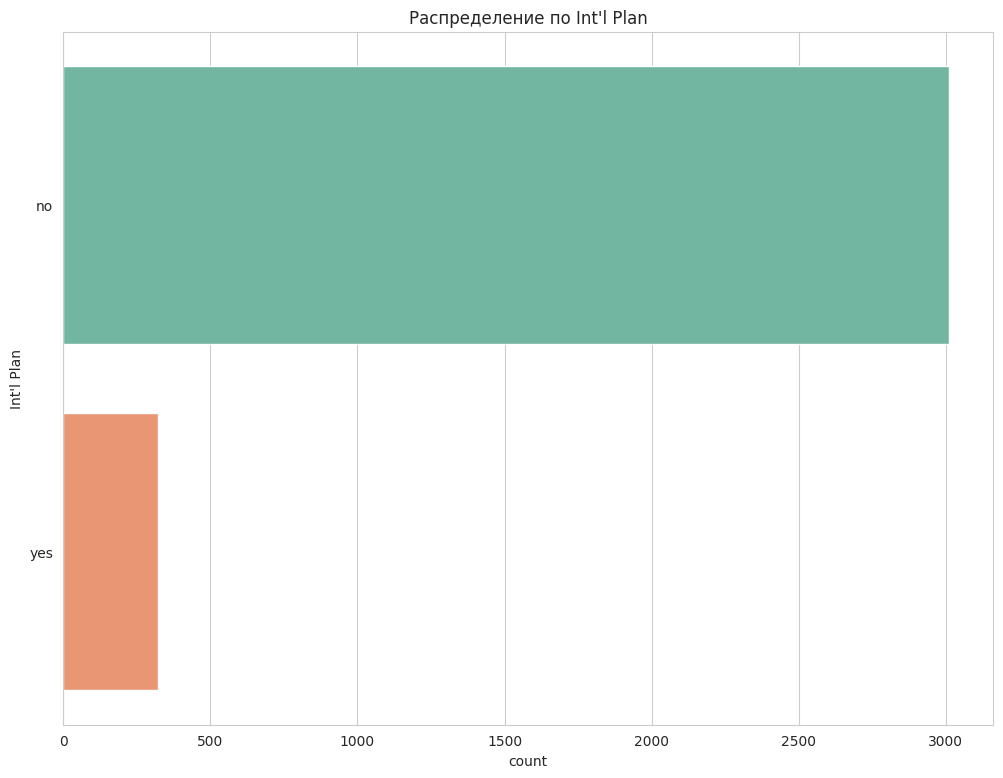

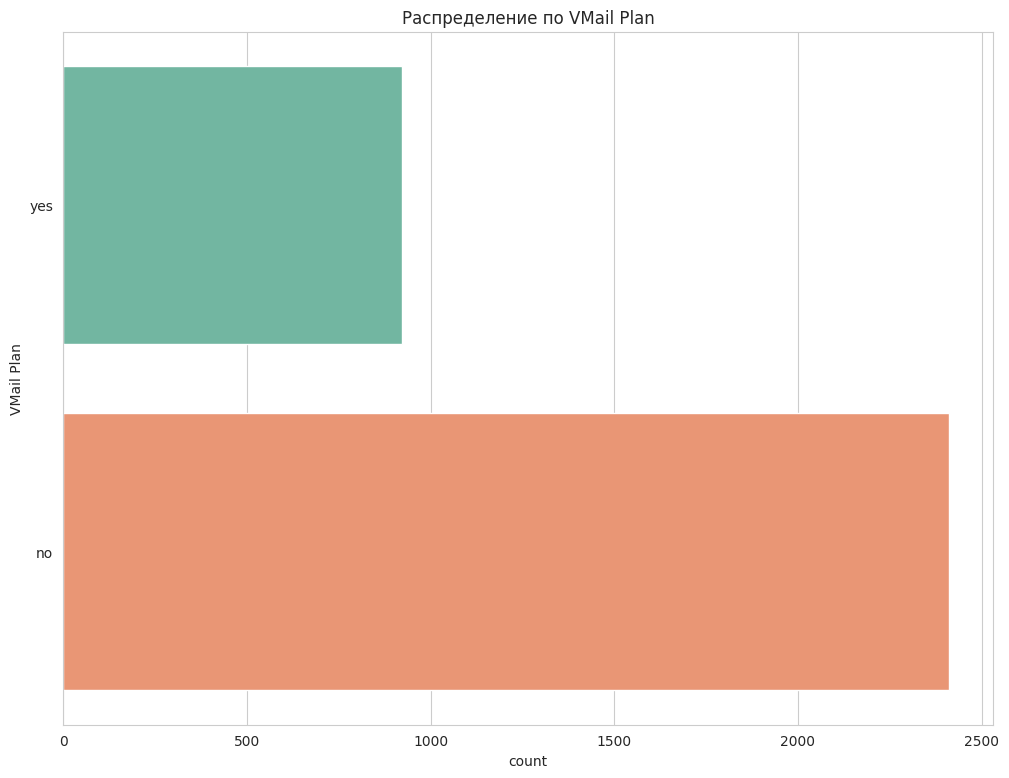

Churn             1.000000
CustServ Calls    0.208750
Day Mins          0.205151
Day Charge        0.205151
Eve Mins          0.092796
Eve Charge        0.092786
Intl Charge       0.068259
Intl Mins         0.068239
Night Charge      0.035496
Night Mins        0.035493
Day Calls         0.018459
Account Length    0.016541
Eve Calls         0.009233
Area Code         0.006174
Night Calls       0.006141
Intl Calls       -0.052844
VMail Message    -0.089728
Name: Churn, dtype: float64


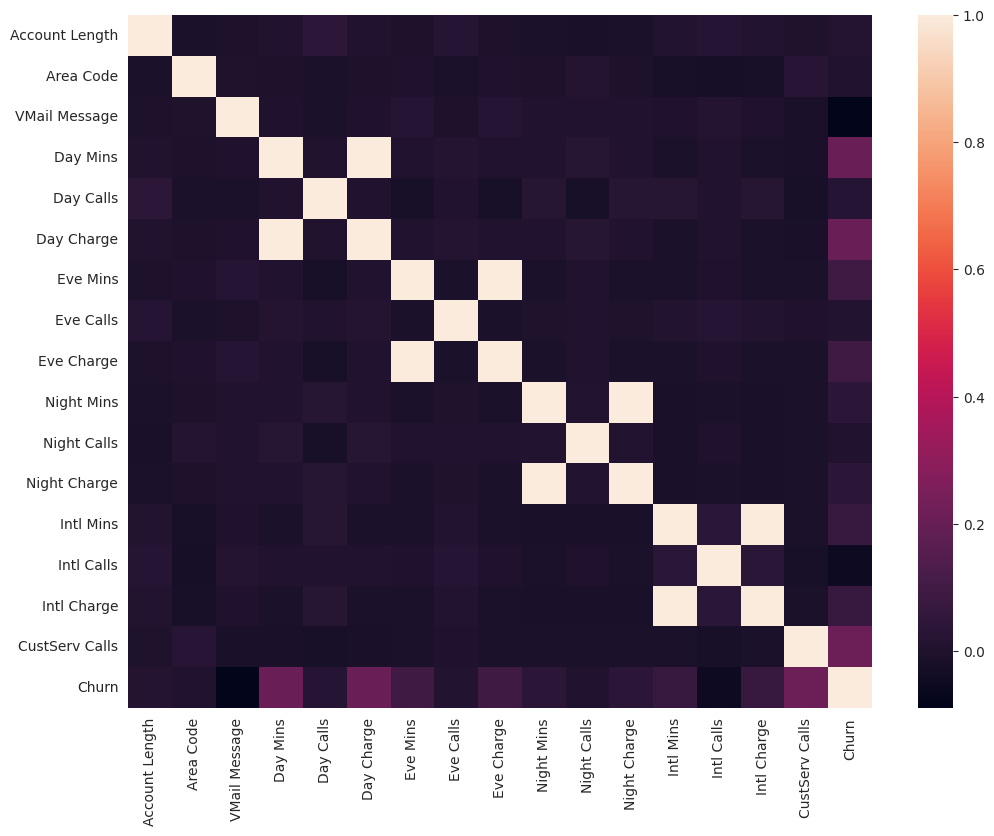

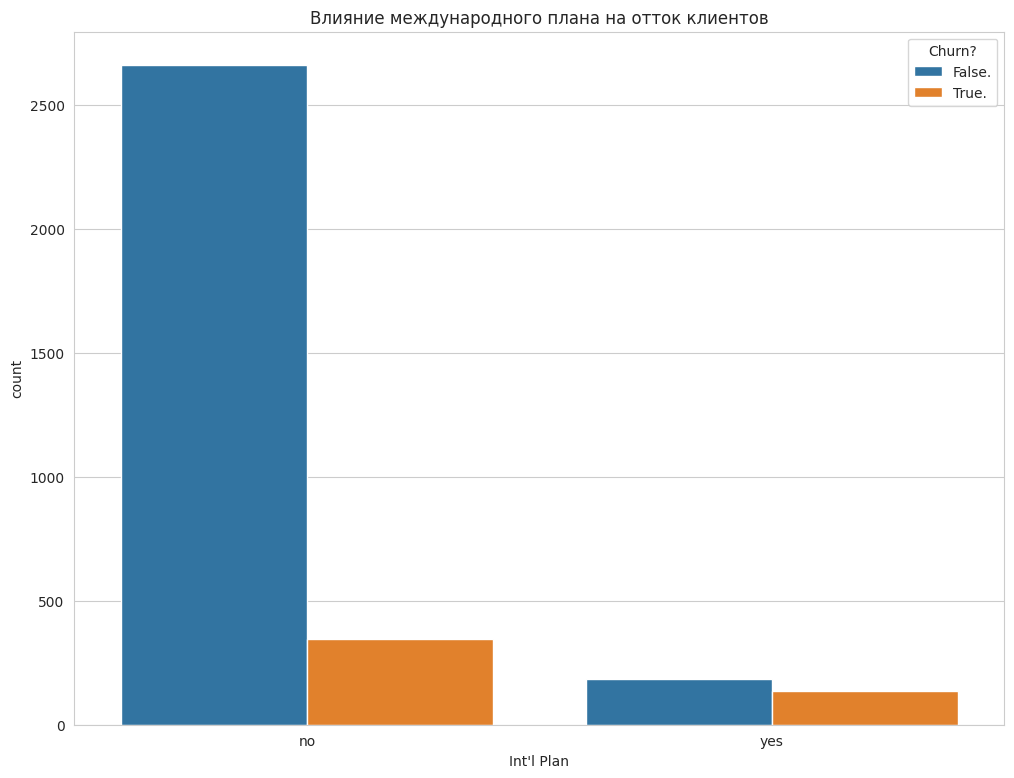

In [139]:
data = pd.read_csv("churn.csv")
print(data.head())
print(data.info())
print(data.describe())
print(data.isnull().sum())
# Визуализация распределения целевой переменной
sns.countplot(x='Churn?', data=data)
plt.title('Распределение оттока клиентов')
plt.show()
# Гистограммы числовых признаков
data.hist(bins=20, figsize=(20,15))
plt.show()
# Визуализация категориальных признаков
for column in data.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        sns.countplot(y=column, data=data, palette="Set2")
        plt.title(f'Распределение по {column}')
        plt.show()
# Корреляция числовых признаков с целевой переменной
numeric_data = data.select_dtypes(include=[np.number])
numeric_data['Churn'] = data['Churn?'].apply(lambda x: 1 if x == 'True.' else 0)
corr_matrix = numeric_data.corr()
print(corr_matrix["Churn"].sort_values(ascending=False))
sns.heatmap(corr_matrix)
plt.show()
# Пример проверки гипотезы
sns.countplot(x='Int\'l Plan', hue='Churn?', data=data)
plt.title('Влияние международного плана на отток клиентов')
plt.show()

In [146]:
# Преобразование категориальных признаков с помощью one-hot encoding
categorical_features = ['State', 'Phone', "Int'l Plan", 'VMail Plan']
data_encoded = pd.get_dummies(data, columns=categorical_features)
X = data_encoded.drop('Churn?', axis=1)
y = data_encoded['Churn?'].apply(lambda x: 1 if x == 'True.' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [147]:
# Настройка гиперпараметров для LGBMClassifier
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
}

lgbm = LGBMClassifier(random_state=42)
grid_search_lgbm = GridSearchCV(lgbm, param_grid_lgbm, cv=5, scoring='accuracy')
grid_search_lgbm.fit(X_train, y_train)
# Настройка гиперпараметров для CatBoostClassifier
param_grid_catboost = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
}
catboost = CatBoostClassifier(verbose=0, random_state=42)
grid_search_catboost = GridSearchCV(catboost, param_grid_catboost, cv=5, scoring='accuracy')
grid_search_catboost.fit(X_train, y_train)
# Выбор лучшей модели и оценка на тестовом наборе
best_model = grid_search_lgbm if grid_search_lgbm.best_score_ > grid_search_catboost.best_score_ else grid_search_catboost
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Лучшая модель: {best_model.best_estimator_}")
print(f"Точность на тестовом наборе: {accuracy}")

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

Лучшая модель: LGBMClassifier(max_depth=7, n_estimators=200, random_state=42)
Точность на тестовом наборе: 0.9490254872563718

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

Когда ждешь, пока оно все посчитает...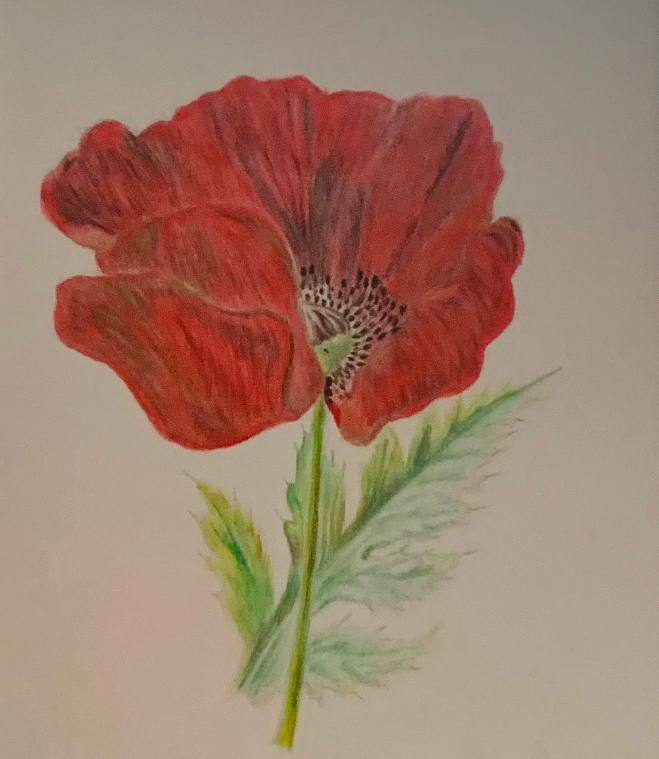

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**